In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from metropolis_hastings import *
from deshuffling_utils import *
import sys  

from nn.rnn_layers import *
from nn.char_nn import *
from nn.optim import *
from nn.sequence_classifier import *
from nn.gradient_check import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))



In [21]:
def train_model(X_train, X_test, char_to_ix, vocab_size, reg, iters=1000, print_every=50, batch_size=50):
    
    #train on the network
    hidden_dims = 100
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]
    
    global model
    
    model = CharNN(char_to_ix, hidden_dims)

    i = 0

    it = iters

    config = {}

    loss_trains = []
    loss_tests = []

    while i < it:
        batch_indices = np.random.choice(N_train, batch_size)
        batch_features = X_train[batch_indices, :]

        loss, grads, _ = model.loss(batch_features)

        for name, value in grads.iteritems():
            if name not in config:
                config[name] = {'learning_rate':1e-3}

            model.params[name], config[name] = adam(model.params[name], value, config[name])

        if i%print_every == 0:
            indices = np.random.choice(N_test, batch_size)
            loss_test, _, _ = model.loss(X_test[indices,:])
            
            print "iter %d, loss_train %f, lost_test %f"%(i, loss, loss_test)
            loss_trains.append(loss)
            loss_tests.append(loss_test)

        i += 1

    plt.plot(loss_trains)
    plt.plot(loss_tests)

    plt.show()
    
    return model


data has 499 characters, 45 unique.
iter 0, loss_train 186.549898, lost_test 186.263057
iter 10, loss_train 172.743391, lost_test 169.195735
iter 20, loss_train 144.363364, lost_test 145.245438
iter 30, loss_train 139.781571, lost_test 141.301408
iter 40, loss_train 138.948981, lost_test 141.136447
iter 50, loss_train 138.607019, lost_test 140.625925
iter 60, loss_train 138.408866, lost_test 140.170922
iter 70, loss_train 138.246915, lost_test 140.005150
iter 80, loss_train 137.587810, lost_test 138.876708
iter 90, loss_train 136.759368, lost_test 138.137963


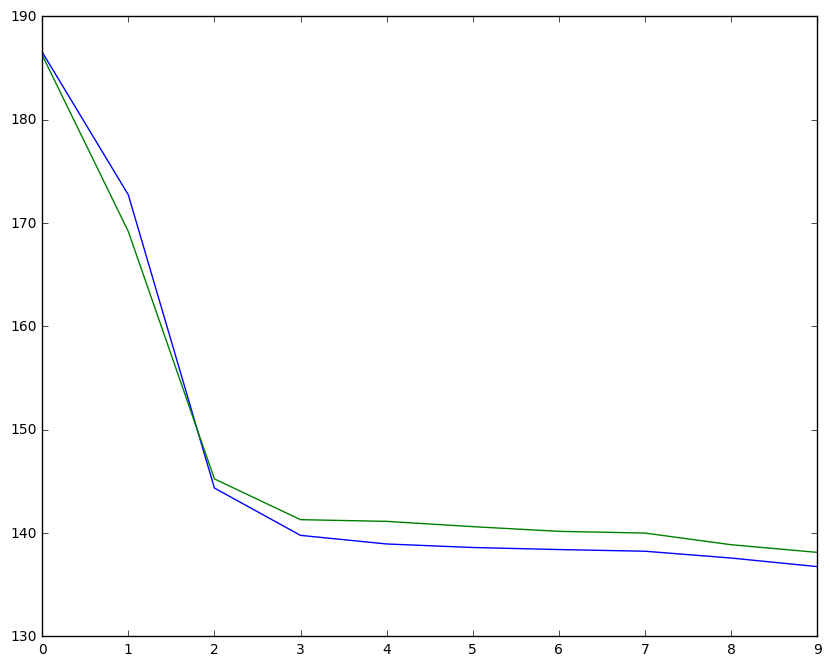

In [16]:
def generate_data(data, seq_len=50):
    
    chars = list(set(data))
    data_size, vocab_size = len(data), len(chars)
    print 'data has %d characters, %d unique.' % (data_size, vocab_size)
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }

    d1 = list(data)
    
    l1 = len(d1)/seq_len
    
    indices = range(l1)
    random.shuffle(indices)
    
    matrix = np.zeros((l1, seq_len), dtype='int')
    
    i = 0
    
    for k in indices:
        matrix[i, :] = [char_to_ix[c] for c in d1[k:k+seq_len]]
        i += 1
    
    p = ((l1)*7)/10
    X_train = matrix[:p,:]
    
    X_test = matrix[p:,:]
    
    return X_train, X_test, char_to_ix, ix_to_char, vocab_size

#test for small data, should overfit
data = open('data/warpeace_input.txt','r').read()
data = data[1:500]

X_train, X_test, char_to_ix, ix_to_char, vocab_size = generate_data(data)

model = train_model(X_train, X_test, char_to_ix, vocab_size, 0.0, iters=100, print_every=10, batch_size=50)


In [22]:
#generate data
data = open('data/warpeace_input.txt','r').read()
X_train, y_train, char_to_ix, ix_to_char, vocab_size = generate_data(data, seq_len=100)

train_model(X_train, X_test, char_to_ix, vocab_size, reg=1e-4, iters=10000, print_every=50, batch_size=50)


data has 3258246 characters, 87 unique.
iter 0, loss_train 442.085475, lost_test 218.820741
iter 50, loss_train 312.873913, lost_test 326.131931
iter 100, loss_train 308.450935, lost_test 334.216639
iter 150, loss_train 308.764306, lost_test 342.216002
iter 200, loss_train 311.347802, lost_test 347.202864
iter 250, loss_train 310.682931, lost_test 351.570312
iter 300, loss_train 309.210127, lost_test 355.396931
iter 350, loss_train 310.521908, lost_test 359.321207
iter 400, loss_train 311.565502, lost_test 362.338233
iter 450, loss_train 310.560995, lost_test 362.934604
iter 500, loss_train 309.448025, lost_test 364.381730
iter 550, loss_train 309.392251, lost_test 367.123772
iter 600, loss_train 307.052061, lost_test 367.562993
iter 650, loss_train 309.404789, lost_test 370.897683
iter 700, loss_train 310.575955, lost_test 371.283195
iter 750, loss_train 310.012199, lost_test 368.400231
iter 800, loss_train 311.160661, lost_test 369.381138
iter 850, loss_train 311.785845, lost_test 37

KeyboardInterrupt: 

In [27]:
#default text to work upon
filename = "data/warpeace_input.txt"
t = list(open(filename, 'r').read()[100:200])
i = 0.
cnt = 0.
while i < 100:
    t1 = shuffle_text(t, 0, len(t))
    x1 = np.array([[char_to_ix[c] for c in t]], dtype='int')
    x2 = np.array([[char_to_ix[c] for c in t1]], dtype='int')

    l1 = model.compute_log_probability(x1)
    l2 = model.compute_log_probability(x2)
    
    #if -l1 <= -l2:
    #print -l1, -l2
    
    cnt += (-l1 > -l2)
    i += 1
    
print cnt/i

0.15
